In [3]:
""" iLINCS Numbers

Here the aim is to come up with preliminary numbers for the iLINCS project - 
to show how much data we have.

Structure:
    a) Load signature data
    b) Numbers for datasets
    c) Numbers for factors
    d) Numbers for conditions
"""

' iLINCS Numbers\n\nHere the aim is to come up with preliminary numbers for the iLINCS project - \nto show how much data we have.\n\nStructure:\n    a) Load signature data\n    b) Numbers for datasets\n    c) Numbers for factors\n    d) Numbers for conditions\n'

## a) Load signature data

In [2]:
"""iLINCS

The exercise here is to quantify HOW many diseases are there for which we have "disease" signatures

Structure:
    1. Imports, Variables, Functions
    2. Retrieve MeSH terms
    3. Retrieve Signature Datasets
    4. Maps MeSH terms to Signatures
    5. Plot Results
"""

# 1. Imports, Variables, FunctionsROOT
import matplotlib.cm as cm
import logging
from Bio import Entrez
import requests
import xml.etree.ElementTree as ET
import time

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)


# variables
Entrez.email = "dylandaltonsub@gmail.com"
base_url = "http://www.ilincs.org/api"
doi_data_path = "../data/DiseaseOntology/doid.obo"
mesh_file_path = "../data/MeSH/desc2023.xml"
d_dataset_2_mesh = dict()
d_signature_2_mesh = dict()
d_mesh_symbol_2_term = dict()
filter_criteria = lambda s: (s["factor"] == "disease.state") and (
    "normal" in s["level2"] or "control" in s["level2"] or "healthy" in s["level2"]
)


# functions
def fetch_disease_signatures(factor):
    """Fetch Disease Signatures"""

    # Construct the filtering JSON based on provided example
    # filter_json = {
    #     "where": {
    #         "factor": factor,
    #         #"baseline": baseline
    #     }
    # }
    # filter_str = json.dumps(filter_json)

    endpoint = f"{base_url}/SignatureMeta"
    # response = requests.get(endpoint, params={"filter": filter_str})
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return []


def extract_disease_names_from_obo(file_path):
    """
    Extracts disease names from an OBO formatted file.

    Args:
    - file_path (str): Path to the OBO file.

    Returns:
    - List[str]: A list of disease names.
    """

    # Open and read the content of the OBO file
    with open(file_path, "r") as f:
        content = f.read()

    # The OBO format divides entries using '[Term]'. We split the content based on this to get individual entries.
    terms = content.split("[Term]")

    disease_names = []  # List to store extracted disease names

    # Iterate over each term/entry
    for term in terms:
        # Use a regular expression to search for the line that starts with 'name: '
        # This line contains the name of the disease.
        match = re.search(r"name: (.+)", term)

        # If a match is found (i.e., the term has a name), extract it and add to the list
        if match:
            disease_name = match.group(
                1
            )  # The actual name is captured in the first group of the regex
            disease_names.append(disease_name)

    return disease_names


def parse_mesh_data(file_path):
    """Parse MeSH XML data and extract disease terms."""
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Extract disease terms
    disease_terms = []
    for descriptor in root.findall("DescriptorRecord"):
        term = descriptor.find("DescriptorName/String").text
        disease_terms.append(term)

    return disease_terms, None


def parse_mesh_data(file_path):
    """Parse MeSH XML data and extract disease terms.

    Retrieve the Botom-Most disease terms which contain the most specific
    information for a disease.

    Parameters:
        file_path: str()

    Return:
        disease_terms: list()
        list_tree_numbers: list()"""
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Extract disease terms
    disease_terms = list()
    list_tree_numbers = list()
    for descriptor in root.findall("DescriptorRecord"):
        # Check if the term is under the category of diseases
        tree_numbers = descriptor.findall("TreeNumberList/TreeNumber")
        for tree_number in tree_numbers:
            # This is a basic check for TreeNumbers starting with 'C' which usually denotes diseases in MeSH
            # You might need to adjust this based on the specific structure of your XML file
            if tree_number.text.startswith("C"):
                list_tree_numbers.append(tree_number.text)
                term = descriptor.find("DescriptorName/String").text
                disease_terms.append(term)
                break  # Break after adding the term to avoid duplicates

    return disease_terms, list_tree_numbers


def extract_pmid_from_publink(publink):
    """Extract the PubMed ID from the provided publink."""
    pmid_match = re.search(r"term=(\d+)\[UID\]", publink)
    if pmid_match:
        return pmid_match.group(1)
    return None


def get_pmid_from_geo_via_eutils(geo_id):
    # Use elink to establish links between GEO and PubMed databases
    handle = Entrez.elink(dbfrom="gds", db="pubmed", id=geo_id[3:])
    record = Entrez.read(handle)
    handle.close()

    # Extract the PMID from the linked records
    # if it has LinkSetDb report else return None
    if len(record[0]["LinkSetDb"]) > 0:
        return record[0]["LinkSetDb"][0][def fetch_disease_signatures():
    """Fetch Disease Signatures"""

    # Construct the filtering JSON based on provided example
    # filter_json = {
    #     "where": {
    #         "factor": factor,
    #         #"baseline": baseline
    #     }
    # }
    # filter_str = json.dumps(filter_json)

    endpoint = f"{base_url}/SignatureMeta"
    # response = requests.get(endpoint, params={"filter": filter_str})
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return []



def fetch_dataset_metadata(dataset_id):
    """Fetch dataset metadata/description for a given dataset."""
    endpoint = f"{base_url}/PublicDatasets/{dataset_id}"
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return None


def fetch_mesh_terms_from_pubmed(pmid):
    """Fetch MeSH terms for a given PubMed ID."""
    if not pmid:
        return []

    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    params = {"db": "pubmed", "id": pmid, "retmode": "xml"}
    response = requests.get(base_url, params=params)
    if response.status_code != 200:
        print(f"Error fetching MeSH terms for PMID {pmid}: {response.text}")
        return []

    # Parse the XML response to extract MeSH terms
    root = ET.fromstring(response.text)
    mesh_terms = [
        descriptor.findtext("DescriptorName")
        for descriptor in root.findall(".//MeshHeading")
    ]

    # Parse the XML response to extract MeSH tree numbers
    mesh_tree_numbers = list()
    for descriptor in root.findall(".//MeshHeading"):
        # Find the DescriptorName element and get its UI attribute
        descriptor_ui = descriptor.find("DescriptorName").get("UI")
        # Use the UI to find the corresponding TreeNumberList/TreeNumber elements
        tree_numbers = root.findall(
            f".//DescriptorRecord[DescriptorUI='{descriptor_ui}']/TreeNumberList/TreeNumber"
        )
        mesh_tree_numbers.extend([tree_number.text for tree_number in tree_numbers])

    return mesh_terms, mesh_tree_numbers


def extract_pmid_from_publink(publink):
    """Extract the PubMed ID from the provided publink."""
    pmid_match = re.search(r"term=(\d+)\[UID\]", publink)
    if pmid_match:
        return pmid_match.group(1)
    return None


def build_mesh_term_tree_number_mapping(mesh_xml_file_path: str) -> dict:
    """
    Build a mapping of MeSH terms to their tree numbers from the MeSH XML file.

    Parameters:
    - mesh_xml_file_path (str): The file path to the MeSH XML file.

    Returns:
    - dict: A dictionary where keys are MeSH terms and values are lists of associated tree numbers.
    """
    tree = ET.parse(mesh_xml_file_path)
    root = tree.getroot()

    mesh_term_2_symbol = dict()
    mesh_symbol_2_term = dict()
    for descriptor in root.findall("DescriptorRecord"):
        term = descriptor.find("DescriptorName/String").text
        tree_numbers = [
            tree_number.text
            for tree_number in descriptor.findall("TreeNumberList/TreeNumber")
        ]
        for tree_number in tree_numbers:
            mesh_symbol_2_term[tree_number] = term
        mesh_term_2_symbol[term] = tree_numbers

    return mesh_term_2_symbol, mesh_symbol_2_term


# 2. Retrieve MeSH terms
# retrieve disease terms and store in dictionary
disease_names_mesh, symbol_mesh = parse_mesh_data(file_path=mesh_file_path)
d_mesh_symbol_2_term = dict(zip(symbol_mesh, disease_names_mesh))

# 3. Retrieve Signature Datasets
start_time = time.time()
logging.info("Starting to Get All Signatures: ")

# get all signatures
signatures = fetch_disease_signatures()

end_time = time.time()
logging.info(
    f"Finished Getting All Signatures. Total time taken: %.4f seconds"
    % (end_time - start_time)
)

2023-12-20 09:18:46,297 - INFO - Starting to Get All Signatures: 
2023-12-20 09:19:10,734 - INFO - Finished Getting All Signatures. Total time taken: 24.4369 seconds


## b) Numbers for datasets

In [2]:
from collections import Counter
import matplotlib.cm as cm

In [4]:
# plot Nº of datasets!
def sort_dict(d_data):
    # Alternative way to sort the dictionary by values in descending order without using lambda
    x = sorted(d_data, key=d_data.get, reverse=True)
    y = [d_data[key] for key in x]

    return x, y


# filter Data
data_plot = Counter([s["datasetid"] for s in signatures if s["libraryid"] == "LIB_1"])

print(f"Nº of Unique Datasets: {len(set(data_plot))}")

Nº of Unique Datasets: 1087


/tmp/ipykernel_26381/630490298.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("Blues")


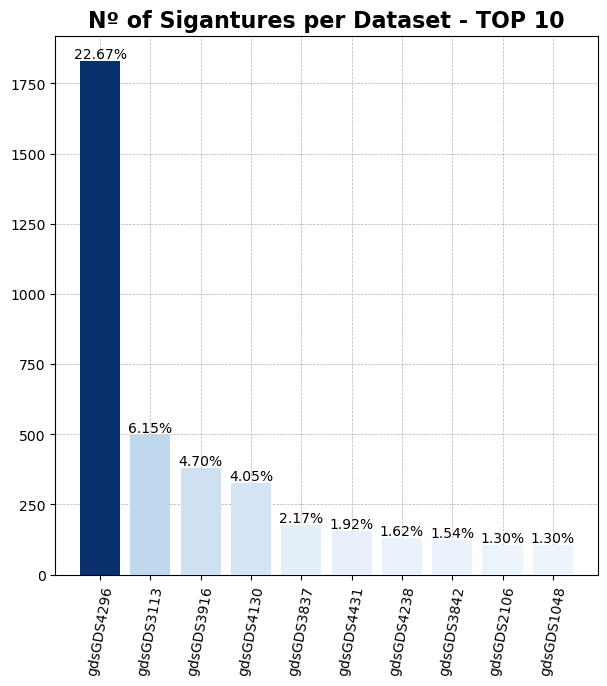

In [5]:
# get data for plot
x, y = sort_dict(data_plot)

# plot
plt.figure(figsize=(7, 7))

# Calculate relative heights (normalized to the range [0, 1])
relative_heights = y[:10] / np.max(y[:10])

# Choose a colormap
cmap = cm.get_cmap("Blues")

# Creating the bar plot with gradient effect
bars = plt.bar(
    x[:10], y[:10], color=[cmap(height) for height in relative_heights], zorder=3
)

plt.xticks(rotation=80)
plt.title(
    "Nº of Sigantures per Dataset - TOP 10",
    fontsize=16,
    fontweight="bold",
)

# Adding data labels on each bar
for bar in bars:
    yval = bar.get_height()
    yval_perc = yval / 9087 * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{yval/8067*100:.2f}%",
        verticalalignment="bottom",
        ha="center",
    )


# Optional: Adding grid lines
plt.grid(True, which="both", linestyle="--", linewidth=0.5, zorder=-2)
plt.savefig(
    "../results/figures/iLINCS/numbers/n_datasets.png", dpi=300, bbox_inches="tight"
)

## c) Numbers for factors


In [59]:
from collections import Counter
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np


# plot Nº of datasets!
def sort_dict(d_data):
    # Alternative way to sort the dictionary by values in descending order without using lambda
    x = sorted(d_data, key=d_data.get, reverse=True)
    y = [d_data[key] for key in x]

    return x, y


# Define Data of interest
data_plot = Counter([s["factor"] for s in signatures if s["libraryid"] == "LIB_1"])

print(f"Nº of Unique Factors: {len(set(data_plot))}")

Nº of Unique Factors: 22


In [66]:
for x_, y_ in zip(x, y):
    print(f"{x_}: {y_}")

cell.line: 1864
time: 1365
disease.state: 1285
other: 948
agent: 831
tissue: 773
age: 411
genotype/variation: 331
specimen: 287
protocol: 269
cell.type: 196
dose: 154
development.stage: 89
infection: 83
strain: 76
gender: 51
stress: 40
growth.protocol: 30
metabolism: 5
temperature: 4
isolate: 3
species: 2


/tmp/ipykernel_100159/1982852845.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(


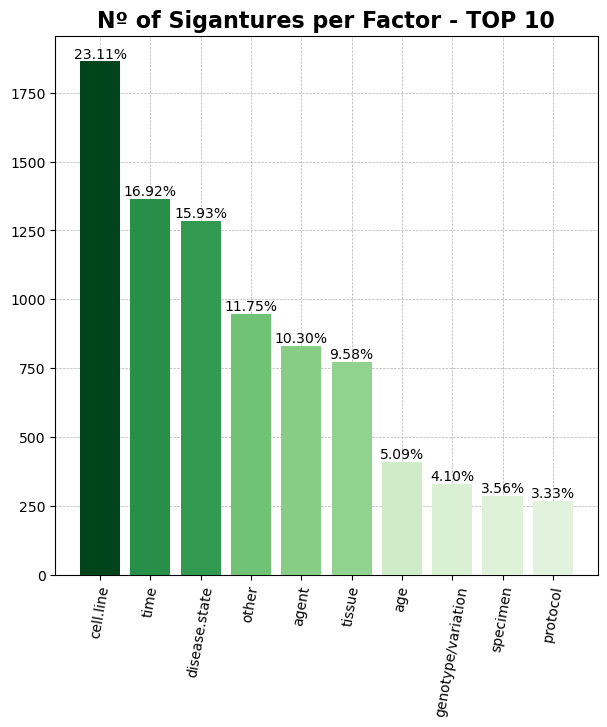

In [60]:
# Define values
x, y = sort_dict(data_plot)

# plot
plt.figure(figsize=(7, 7))


# Calculate relative heights (normalized to the range [0, 1])
relative_heights = y[:10] / np.max(y[:10])

# Choose a colormap
cmap = cm.get_cmap(
    "Greens"
)  # You can choose different colormaps like 'Reds', 'Greens', etc.

# Creating the bar plot with gradient effect
bars = plt.bar(
    x[:10], y[:10], color=[cmap(height) for height in relative_heights], zorder=3
)


plt.xticks(rotation=80)
plt.title(
    "Nº of Sigantures per Factor - TOP 10",
    fontsize=16,
    fontweight="bold",
)

# Adding data labels on each bar
for bar in bars:
    yval = bar.get_height()
    yval_perc = yval / 9087 * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{yval/8067*100:.2f}%",
        verticalalignment="bottom",
        ha="center",
    )


# Optional: Adding grid lines
plt.grid(True, which="both", linestyle="--", linewidth=0.5, zorder=-2)
plt.savefig(
    "../results/figures/iLINCS/numbers/n_factors.png", dpi=300, bbox_inches="tight"
)

## d) Numbers for conditions

In [8]:
from collections import Counter
import matplotlib.cm as cm


# plot Nº of datasets!
def sort_dict(d_data):
    # Alternative way to sort the dictionary by values in descending order without using lambda
    x = sorted(d_data, key=d_data.get, reverse=True)
    y = [d_data[key] for key in x]

    return x, y


# Define Data of interest
data_plot_ = [s["level1"] for s in signatures if s["libraryid"] == "LIB_1"]
data_plot_.extend([s["level2"] for s in signatures if s["libraryid"] == "LIB_1"])

print(f"Nº of Unique Conditions: {len(set(data_plot))}")

Nº of Unique Conditions: 22


/tmp/ipykernel_26381/1541039538.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(


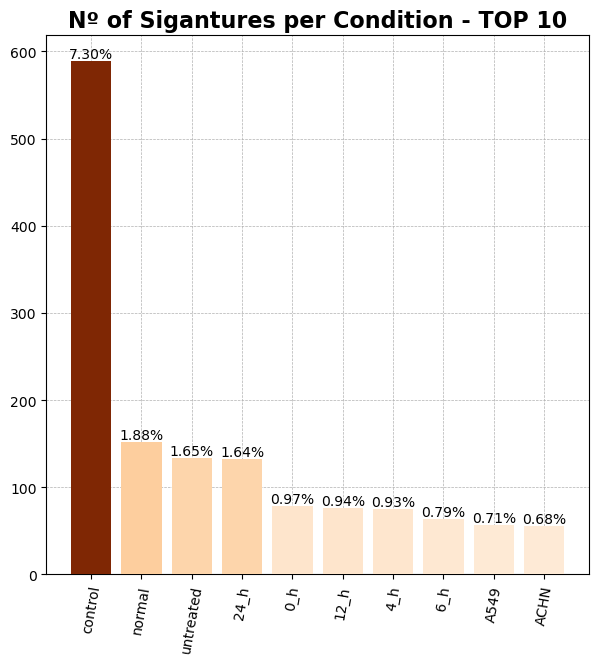

In [9]:
data_plot = Counter(data_plot_)

# Define values
x, y = sort_dict(data_plot)

# plot
plt.figure(figsize=(7, 7))


# Calculate relative heights (normalized to the range [0, 1])
relative_heights = y[:10] / np.max(y[:10])

# Choose a colormap
cmap = cm.get_cmap(
    "Oranges"
)  # You can choose different colormaps like 'Reds', 'Greens', etc.

# Creating the bar plot with gradient effect
bars = plt.bar(
    x[:10], y[:10], color=[cmap(height) for height in relative_heights], zorder=3
)


plt.xticks(rotation=80)
plt.title(
    "Nº of Sigantures per Condition - TOP 10",
    fontsize=16,
    fontweight="bold",
)

# Adding data labels on each bar
for bar in bars:
    yval = bar.get_height()
    yval_perc = yval / 9087 * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{yval/8067*100:.2f}%",
        verticalalignment="bottom",
        ha="center",
    )


# Optional: Adding grid lines
plt.grid(True, which="both", linestyle="--", linewidth=0.5, zorder=-2)
plt.savefig(
    "../results/figures/iLINCS/numbers/n_conditions.png", dpi=300, bbox_inches="tight"
)

## e) Nº Conditions per Factor

In [17]:
from collections import Counter
import matplotlib.cm as cm


# plot Nº of datasets!
def sort_dict(d_data):
    # Alternative way to sort the dictionary by values in descending order without using lambda
    x = sorted(d_data, key=d_data.get, reverse=True)
    y = [d_data[key] for key in x]

    return x, y


# Define Data of interest
data_plot_ = [
    s["level1"]
    for s in signatures
    if (s["libraryid"] == "LIB_1") and (s["factor"] == "cell.line")
]
data_plot_.extend(
    [
        s["level2"]
        for s in signatures
        if s["libraryid"] == "LIB_1" and (s["factor"] == "cell.line")
    ]
)

print(f"Nº of Unique Conditions: {len(set(data_plot))}")

Nº of Unique Conditions: 239


/tmp/ipykernel_26381/2325226783.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(


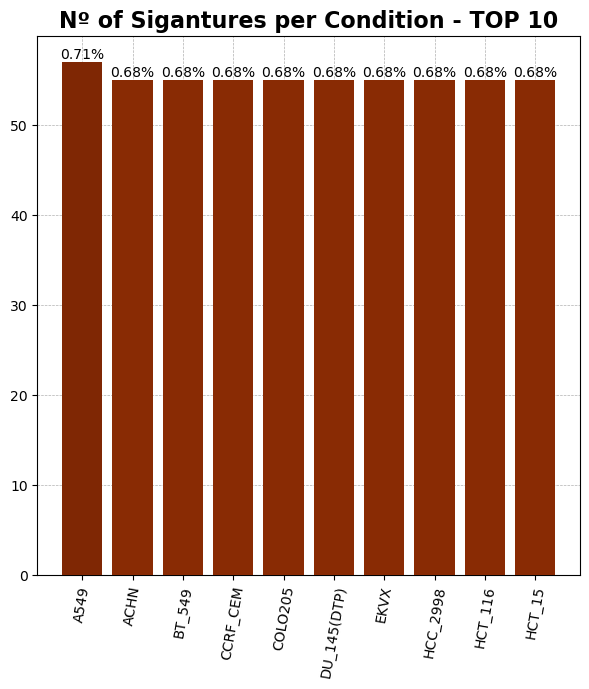

In [18]:
data_plot = Counter(data_plot_)

# Define values
x, y = sort_dict(data_plot)

# plot
plt.figure(figsize=(7, 7))


# Calculate relative heights (normalized to the range [0, 1])
relative_heights = y[:10] / np.max(y[:10])

# Choose a colormap
cmap = cm.get_cmap(
    "Oranges"
)  # You can choose different colormaps like 'Reds', 'Greens', etc.

# Creating the bar plot with gradient effect
bars = plt.bar(
    x[:10], y[:10], color=[cmap(height) for height in relative_heights], zorder=3
)


plt.xticks(rotation=80)
plt.title(
    "Nº of Sigantures per Condition - TOP 10",
    fontsize=16,
    fontweight="bold",
)

# Adding data labels on each bar
for bar in bars:
    yval = bar.get_height()
    yval_perc = yval / 9087 * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{yval/8067*100:.2f}%",
        verticalalignment="bottom",
        ha="center",
    )


# Optional: Adding grid lines
plt.grid(True, which="both", linestyle="--", linewidth=0.5, zorder=-2)
# plt.savefig(
#     "../results/figures/iLINCS/numbers/n_conditions.png", dpi=300, bbox_inches="tight"
# )

In [24]:
import requests
import json


def query_cellosaurus(cell_line):
    # Cellosaurus API endpoint for querying a specific cell line
    url = f"https://web.expasy.org/cgi-bin/cellosaurus/api/cell-line/{cell_line}?format=json"

    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        # Extracting disease information, assuming it's under a key like 'disease' or similar
        # The exact key name should be checked in the API response or documentation
        disease = data.get("disease", {}).get(
            "name", "Disease information not available"
        )
        return disease
    else:
        return f"Error querying Cellosaurus: {response.status_code}"


# Example usage
cell_line_disease = query_cellosaurus("A549")
print(cell_line_disease)

<Response [404]>
Error querying Cellosaurus: 404


## f) MeSH terms

### f.1) MeSH terms for each dataset

In [ ]:
""" MeSH Terms for each dataset

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Retrieve MeSH symbols
"""

# 1. Imports, Variables, Functions
# imports
import requests
import xml.etree.ElementTree as ET
import time, re
from Bio import Entrez
import logging
import pandas as pd
import json

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
# variables
base_url = "http://www.ilincs.org/api"


# functions
def get_disease_datasets():
    """
    Get Disease Datasets
    Function to retrieve from those filtered signatures the datasetid

    Arguments:

    Return:
    datasetid: list()
        List of unique dataset id's
    """
    path_data = "../../data/iLINCS/signatures.csv"
    filter_df = lambda df: df["libraryid"] == "LIB_1"

    # Load Data
    try:
        df_data = pd.read_csv(path_data)
        logging.info("Data loaded successfully.")
    except FileNotFoundError:
        logging.error("Data file not found. Please check the file path.")
        exit()

    # filter disease signatures
    df_data = df_data[filter_df]

    return list(df_data["datasetid"].unique())


def build_mesh_term_tree_number_mapping(mesh_xml_file_path: str) -> dict:
    """
    Build a mapping of MeSH terms to their tree numbers from the MeSH XML file.

    Parameters:
    - mesh_xml_file_path (str): The file path to the MeSH XML file.

    Returns:
    - dict: A dictionary where keys are MeSH terms and values are lists of associated tree numbers.
    """
    tree = ET.parse(mesh_xml_file_path)
    root = tree.getroot()

    mesh_term_2_symbol = dict()
    mesh_symbol_2_term = dict()
    for descriptor in root.findall("DescriptorRecord"):
        term = descriptor.find("DescriptorName/String").text
        tree_numbers = [
            tree_number.text
            for tree_number in descriptor.findall("TreeNumberList/TreeNumber")
        ]
        for tree_number in tree_numbers:
            mesh_symbol_2_term[tree_number] = term
        mesh_term_2_symbol[term] = tree_numbers

    return mesh_term_2_symbol, mesh_symbol_2_term


# 2. Load Data
# load datasets
datasets = get_disease_datasets()

# load MeSH terms from datasets
# generated in SQL notebook
with open("../data/iLINCS/dataset_2_mesh.json", "r") as f:
    d_dataset_2_mesh_original = json.load(f)

# load mesh terms
mesh_term_2_symbol, mesh_symbol_2_term = build_mesh_term_tree_number_mapping(
    mesh_file_path
)

In [ ]:
# 3. Retrieve MeSH symbols
# we can retrieve from pmid the mesh terms but we need to map these to symbols
failed_translation_all = list()
d_dataset_2_mesh = dict()

for k, MeSH_terms in d_dataset_2_mesh_original.items():
    tree_symbols = list()
    terms = list()
    failed_translation = list()
    d_dataset_2_mesh[k] = dict()

    for MeSH_term in MeSH_terms[0]:
        try:
            tree_symbols.extend(mesh_term_2_symbol[MeSH_term])
            terms.append(MeSH_term)
            # print(mesh_term_2_symbol[MeSH_term])
        except:
            failed_translation.append(MeSH_term)
            failed_translation_all.append(MeSH_term)
    d_dataset_2_mesh[k]["symbol"] = tree_symbols
    d_dataset_2_mesh[k]["terms"] = terms

#### f.1.1) MeSH terms for each dataset - root terms

In [26]:
# Get ROOT terms ! ! !
# exclude terms that are not diseases
# exclude C23: Pathological Conditions, Signs and Symptoms
level = 0
level_split = level * 4 + 3
all_symbols = list()
filter_criteria = lambda t: t.startswith("C") and not t.startswith("C23")


for k in d_dataset_2_mesh.keys():
    if d_dataset_2_mesh[k]["symbol"] is not None:
        terms = d_dataset_2_mesh[k]["symbol"]

        terms_specific_level = list(
            set([t[:level_split] for t in terms if filter_criteria(t)])
        )
        all_symbols.extend(terms_specific_level)


# translate terms
all_terms = [mesh_symbol_2_term[s] for s in all_symbols]

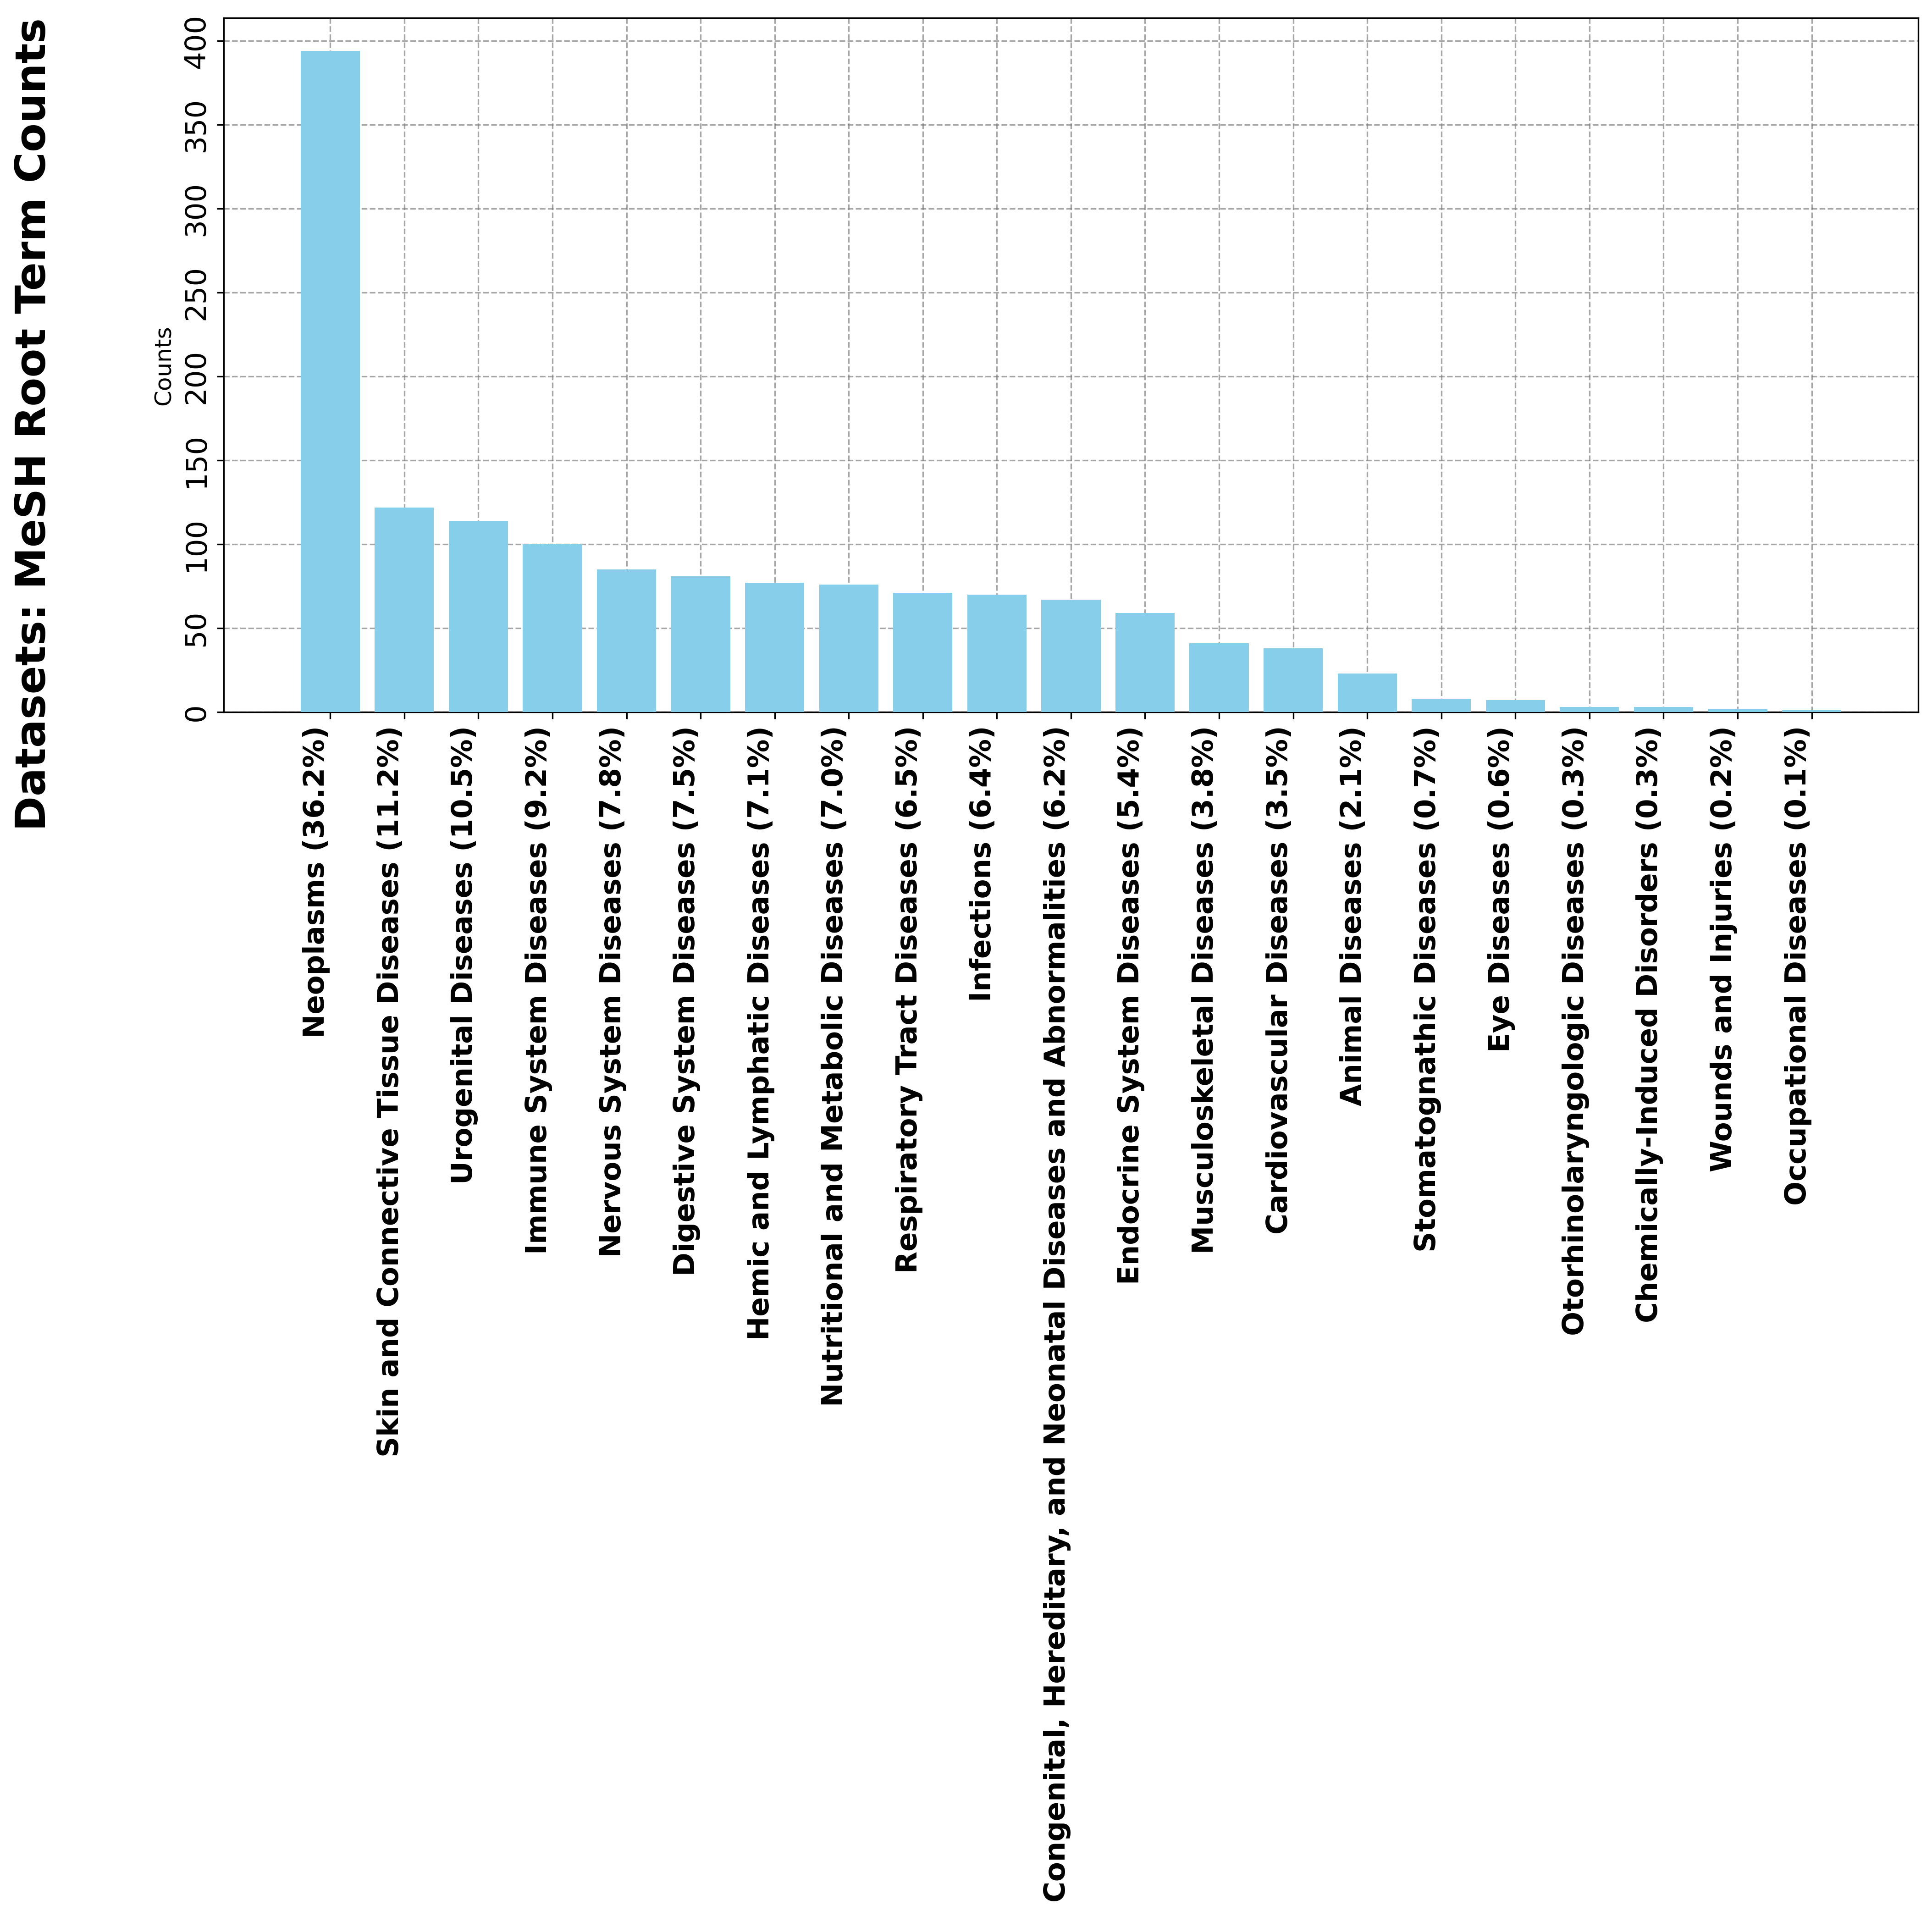

In [27]:
import matplotlib.pyplot as plt
from collections import Counter


# Count the occurrences of each category
category_counts = Counter(all_terms)


# Sort the categories by count in descending order
sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
labels, values = zip(*sorted_categories)
labels_perc = [f"{l} ({v/1087*100:.1f}%)" for l, v in zip(labels, values)]

# Create the bar plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 14), dpi=300)
plt.bar(labels_perc, values, color="skyblue", zorder=3)

# Add title and labels to the plot
# plt.title('MeSH Term Counts Hierarchy Level %d' %level,fontsize=22)

# Manually add a title-like text above the y-axis label
ax.text(
    -0.1,
    1,
    "Datasets: MeSH Root Term Counts",
    fontsize=22,
    transform=ax.transAxes,
    fontweight="bold",
    va="top",
    ha="right",
    rotation=90,
)

plt.ylabel("Counts", fontsize=12)

# Add grid lines with a white background
ax.set_facecolor("white")  # Set the background color to white

# plt.grid(axis='y', color='r', linestyle='--', alpha=0.7)
plt.grid(color="grey", linestyle="--", alpha=0.7, zorder=1)

# Add edges
ax.spines["bottom"].set_color("0")
ax.spines["top"].set_color("0")
ax.spines["right"].set_color("0")
ax.spines["left"].set_color("0")

# Rotate the category labels for better readability (if needed)
plt.yticks(rotation=90, va="center", fontsize=15)


# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, ha="right", fontsize=15, fontweight="bold")

# Show the plot
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.savefig(
    "../results/figures/iLINCS/numbers/n_mesh.datasets.root.png",
    dpi=300,
    bbox_inches="tight",
)

#### f.1.2) MeSH terms for each dataset - specific terms

In [19]:
# Get SPECIFIC terms ! ! !
# exclude terms that are not diseases
# exclude C23: Pathological Conditions, Signs and Symptoms

level = 0
level_split = level * 4 + 3
all_symbols = list()
filter_criteria = lambda t: t.startswith("C") and not t.startswith("C23")


def find_longest_string(lst):
    """Find Longets String in a list
    Parameters:
        lst: list()
    Return:
        longest: str()
    """
    longest = ""
    for item in lst:
        if len(item) > len(longest):
            longest = item
    # alternative
    # longest = max(lst, key=len)
    return longest


# root terms
root_terms = set([s[:3] for s in mesh_symbol_2_term.keys() if filter_criteria(s)])
all_symbols = list()

for k in d_dataset_2_mesh.keys():
    if d_dataset_2_mesh[k]["symbol"] is not None:
        terms = d_dataset_2_mesh[k]["symbol"]
        # iterate through different root terms
        for root_term in root_terms:
            terms_for_root = [t for t in terms if t.startswith(root_term)]
            if len(terms) > 0:
                longest_length_term = find_longest_string(terms_for_root)
                all_symbols.extend(
                    [t for t in terms_for_root if len(t) == len(longest_length_term)]
                )


# translate terms
all_terms = [mesh_symbol_2_term[s] for s in all_symbols]

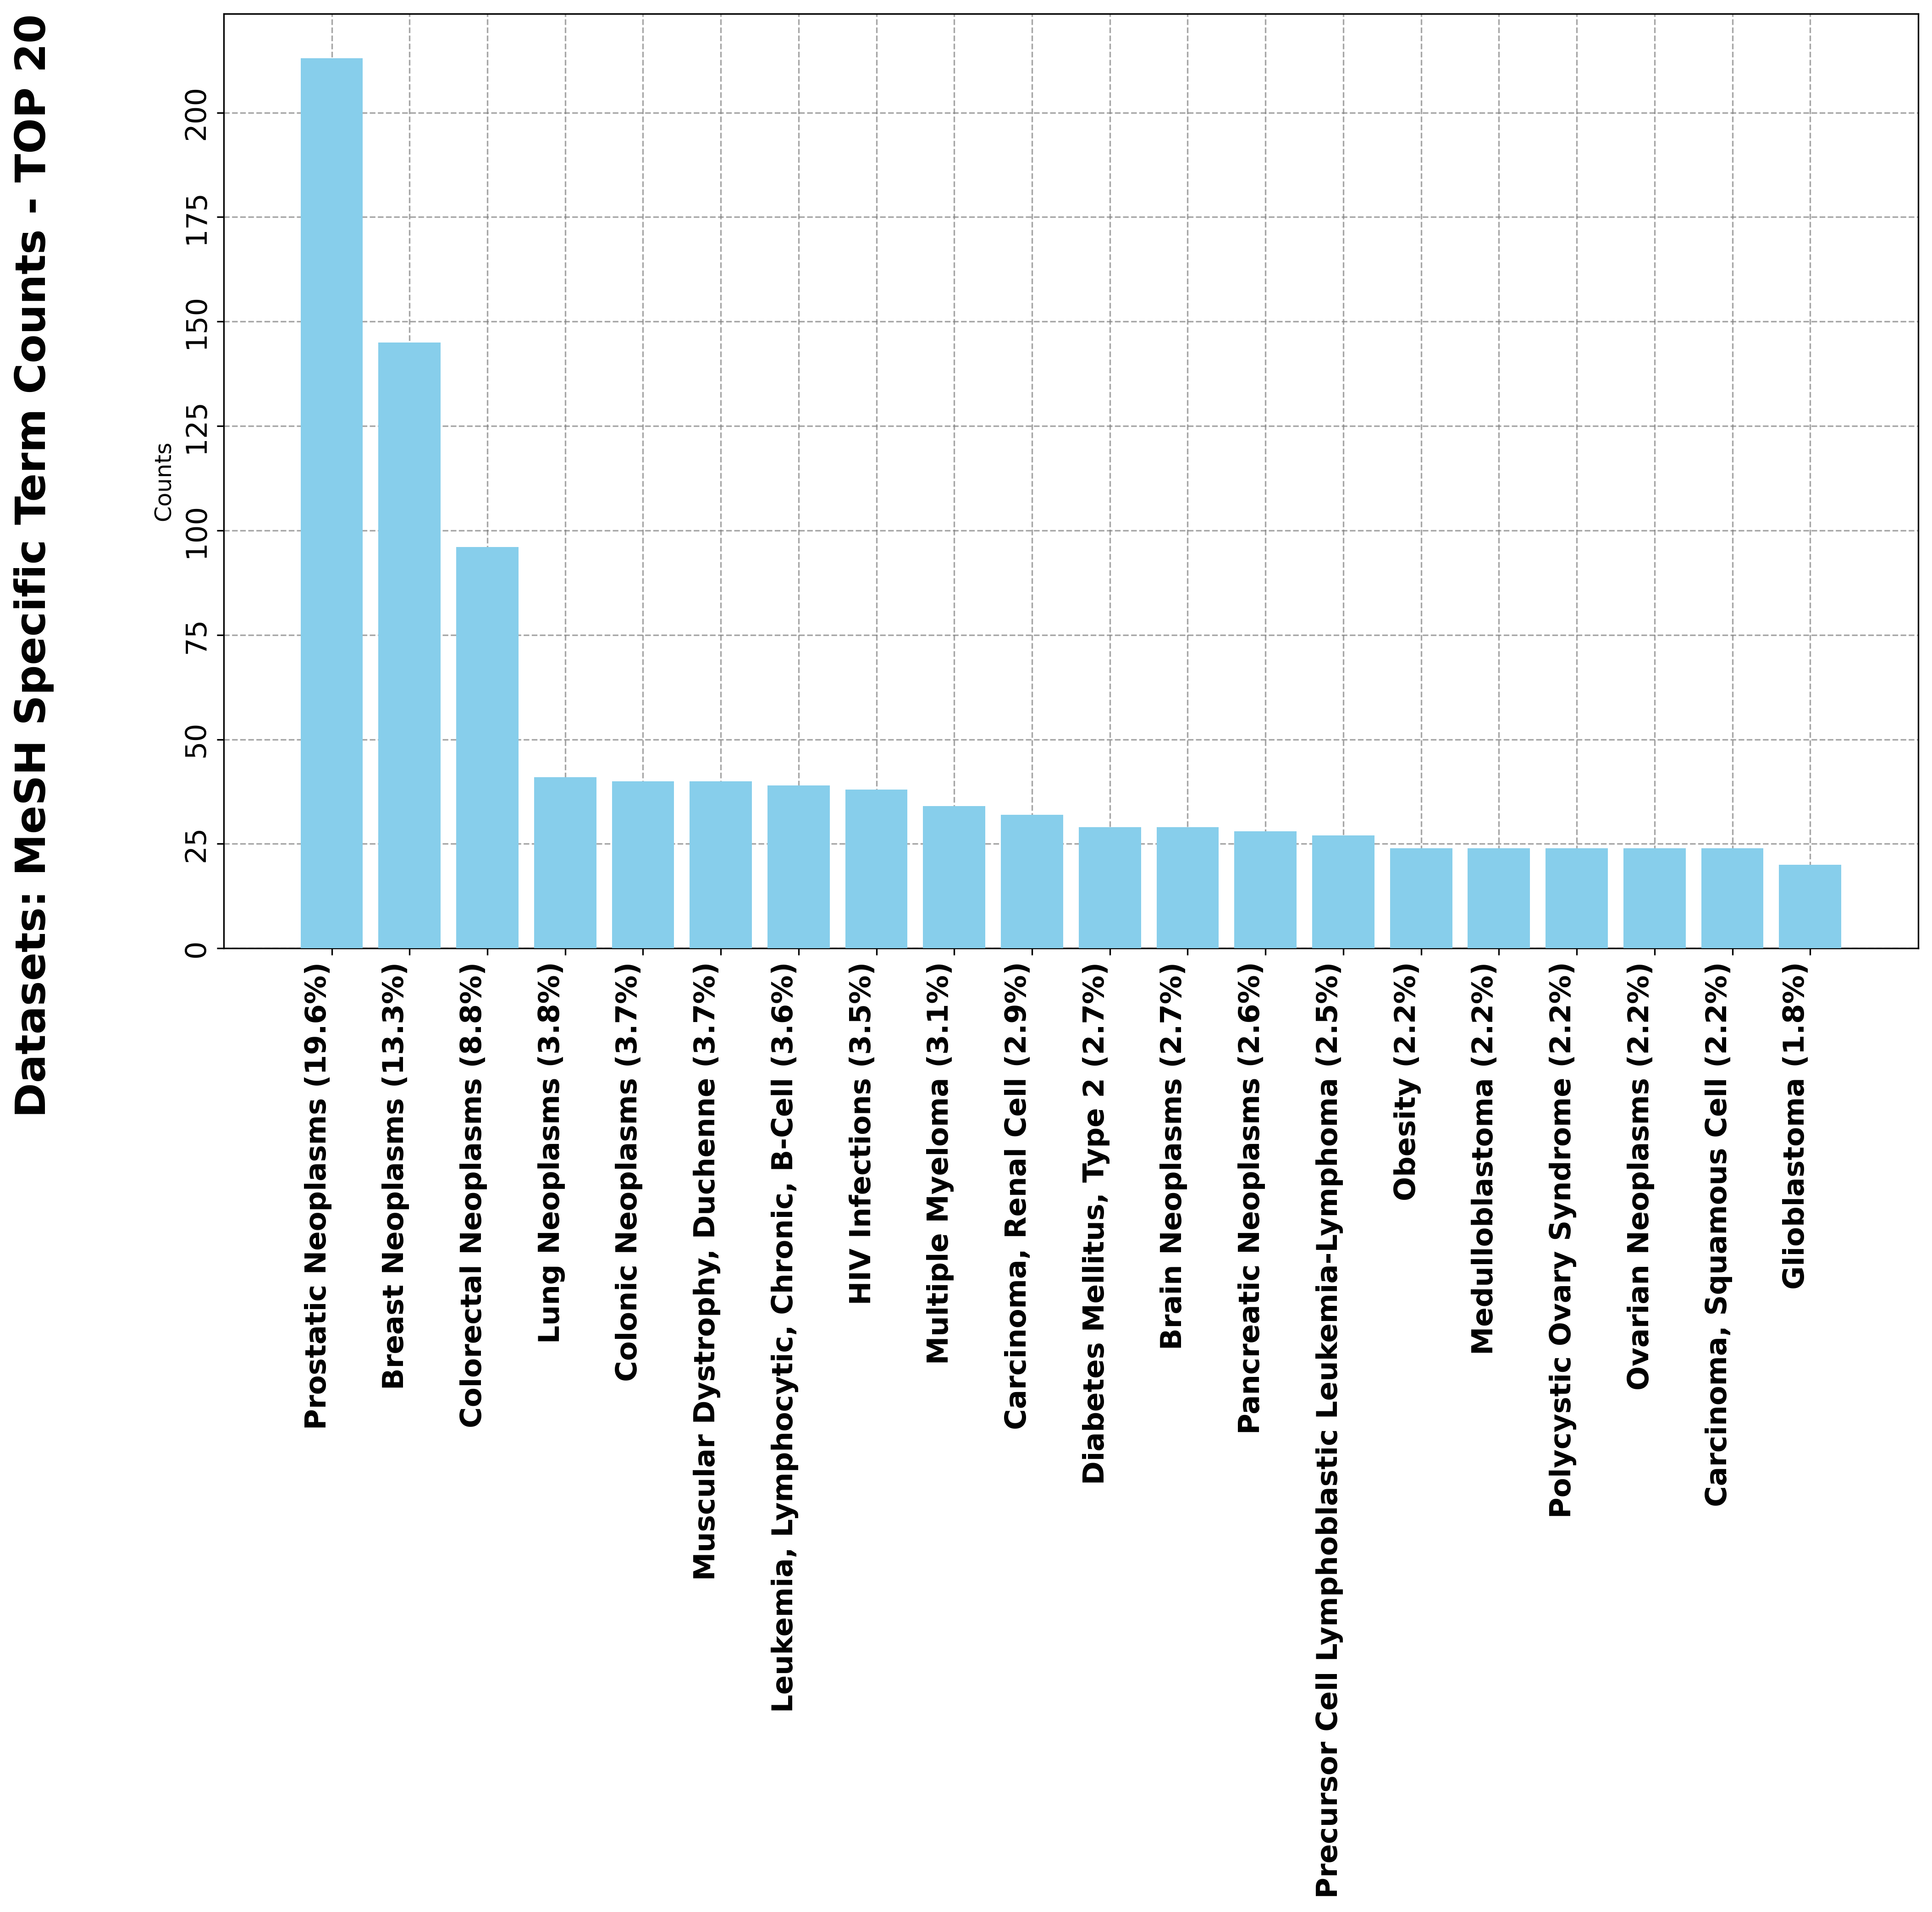

In [25]:
import matplotlib.pyplot as plt
from collections import Counter

# TOP N
top_n = 20

# Count the occurrences of each category
category_counts = Counter(all_terms)

# Sort the categories by count in descending order
sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
labels, values = zip(*sorted_categories)
labels_perc = [f"{l} ({v/1087*100:.1f}%)" for l, v in zip(labels, values)]

# Create the bar plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 14), dpi=300)
plt.bar(labels_perc[:top_n], values[:top_n], color="skyblue", zorder=3)

# Add title and labels to the plot
# plt.title('MeSH Term Counts Hierarchy Level %d' %level,fontsize=22)

# Manually add a title-like text above the y-axis label
ax.text(
    -0.1,
    1,
    f"Datasets: MeSH Specific Term Counts - TOP {top_n}",
    fontsize=22,
    transform=ax.transAxes,
    fontweight="bold",
    va="top",
    ha="right",
    rotation=90,
)

plt.ylabel("Counts", fontsize=12)

# Add grid lines with a white background
ax.set_facecolor("white")  # Set the background color to white

# plt.grid(axis='y', color='r', linestyle='--', alpha=0.7)
plt.grid(color="grey", linestyle="--", alpha=0.7, zorder=1)

# Add edges
ax.spines["bottom"].set_color("0")
ax.spines["top"].set_color("0")
ax.spines["right"].set_color("0")
ax.spines["left"].set_color("0")

# Rotate the category labels for better readability (if needed)
plt.yticks(rotation=90, va="center", fontsize=15)


# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, ha="right", fontsize=15, fontweight="bold")

# Show the plot
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.savefig(
    "../results/figures/iLINCS/numbers/n_mesh.datasets.specific.png",
    dpi=300,
    bbox_inches="tight",
)

### f.2) MeSH terms for each signature

In [30]:
""" MeSH Terms for each dataset

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Retrieve MeSH symbols
"""

# 1. Imports, Variables, Functions
# imports
import requests
import xml.etree.ElementTree as ET
import time, re
from Bio import Entrez
import logging
import pandas as pd
import json

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
# variables
base_url = "http://www.ilincs.org/api"
mesh_file_path = "../data/MeSH/desc2023.xml"


# functions
def get_disease_datasets():
    """
    Get Disease Datasets
    Function to retrieve from those filtered signatures the datasetid

    Arguments:

    Return:
    datasetid: list()
        List of unique dataset id's
    """
    path_data = "../data/iLINCS/signatures.csv"
    filter_df = lambda df: df["libraryid"] == "LIB_1"

    # Load Data
    try:
        df_data = pd.read_csv(path_data)
        logging.info("Data loaded successfully.")
    except FileNotFoundError:
        logging.error("Data file not found. Please check the file path.")
        exit()

    # filter disease signatures
    df_data = df_data[filter_df]

    return list(df_data["datasetid"].unique())


def get_disease_datasets_all():
    """
    Get Disease Datasets
    Function to retrieve from those filtered signatures the datasetid

    Arguments:

    Return:
    datasetid: list()
        List of unique dataset id's
    """
    path_data = "../data/iLINCS/signatures.csv"
    filter_df = lambda df: df["libraryid"] == "LIB_1"

    # Load Data
    try:
        df_data = pd.read_csv(path_data)
# 1. Imports, Variables, Functions
# imports


# variables
    # filter disease signatures
    df_data = df_data[filter_df]

    return df_data["datasetid"].to_list()


def build_mesh_term_tree_number_mapping(mesh_xml_file_path: str) -> dict:
    """
    Build a mapping of MeSH terms to their tree numbers from the MeSH XML file.

    Parameters:
    - mesh_xml_file_path (str): The file path to the MeSH XML file.

    Returns:
    - dict: A dictionary where keys are MeSH terms and values are lists of associated tree numbers.
    """
    tree = ET.parse(mesh_xml_file_path)
    root = tree.getroot()

    mesh_term_2_symbol = dict()
    mesh_symbol_2_term = dict()
    for descriptor in root.findall("DescriptorRecord"):
        term = descriptor.find("DescriptorName/String").text
        tree_numbers = [
            tree_number.text
            for tree_number in descriptor.findall("TreeNumberList/TreeNumber")
        ]
        for tree_number in tree_numbers:
            mesh_symbol_2_term[tree_number] = term
        mesh_term_2_symbol[term] = tree_numbers

    return mesh_term_2_symbol, mesh_symbol_2_term


# 2. Load Data
# load datasets
datasets = get_disease_datasets_all()

# load MeSH terms from datasets
# generated in SQL notebook
with open("../data/iLINCS/dataset_2_mesh.json", "r") as f:
    d_dataset_2_mesh_original = json.load(f)

# load mesh terms
mesh_term_2_symbol, mesh_symbol_2_term = build_mesh_term_tree_number_mapping(
    mesh_file_path
)

/tmp/ipykernel_100159/2221400539.py:72: DtypeWarning: Columns (0,3,7,8,9,10,15,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv(path_data)
2023-12-20 11:05:46,934 - INFO - Data loaded successfully.


In [4]:
# 3. Retrieve MeSH symbols
# we can retrieve from pmid the mesh terms but we need to map these to symbols
failed_translation_all = list()
d_dataset_2_mesh = dict()

for k, MeSH_terms in d_dataset_2_mesh_original.items():
    tree_symbols = list()
    terms = list()
    failed_translation = list()
    d_dataset_2_mesh[k] = dict()

    for MeSH_term in MeSH_terms[0]:
        try:
            tree_symbols.extend(mesh_term_2_symbol[MeSH_term])
            terms.append(MeSH_term)
            # print(mesh_term_2_symbol[MeSH_term])
        except:
            failed_translation.append(MeSH_term)
            failed_translation_all.append(MeSH_term)
    d_dataset_2_mesh[k]["symbol"] = tree_symbols
    d_dataset_2_mesh[k]["terms"] = terms

#### f.2.1) MeSH terms for each signature - root terms

In [52]:
# Get ROOT terms ! ! !
# exclude terms that are not diseases
# exclude C23: Pathological Conditions, Signs and Symptoms
level = 0
level_split = level * 4 + 3
all_symbols = list()
filter_criteria = lambda t: t.startswith("C") and not t.startswith("C23")


for k in datasets:
    if k in d_dataset_2_mesh.keys() and d_dataset_2_mesh[k]["symbol"] is not None:
        terms = d_dataset_2_mesh[k]["symbol"]

        terms_specific_level = list(
            set([t[:level_split] for t in terms if filter_criteria(t)])
        )
        all_symbols.extend(terms_specific_level)


# translate terms
all_terms = [mesh_symbol_2_term[s] for s in all_symbols]

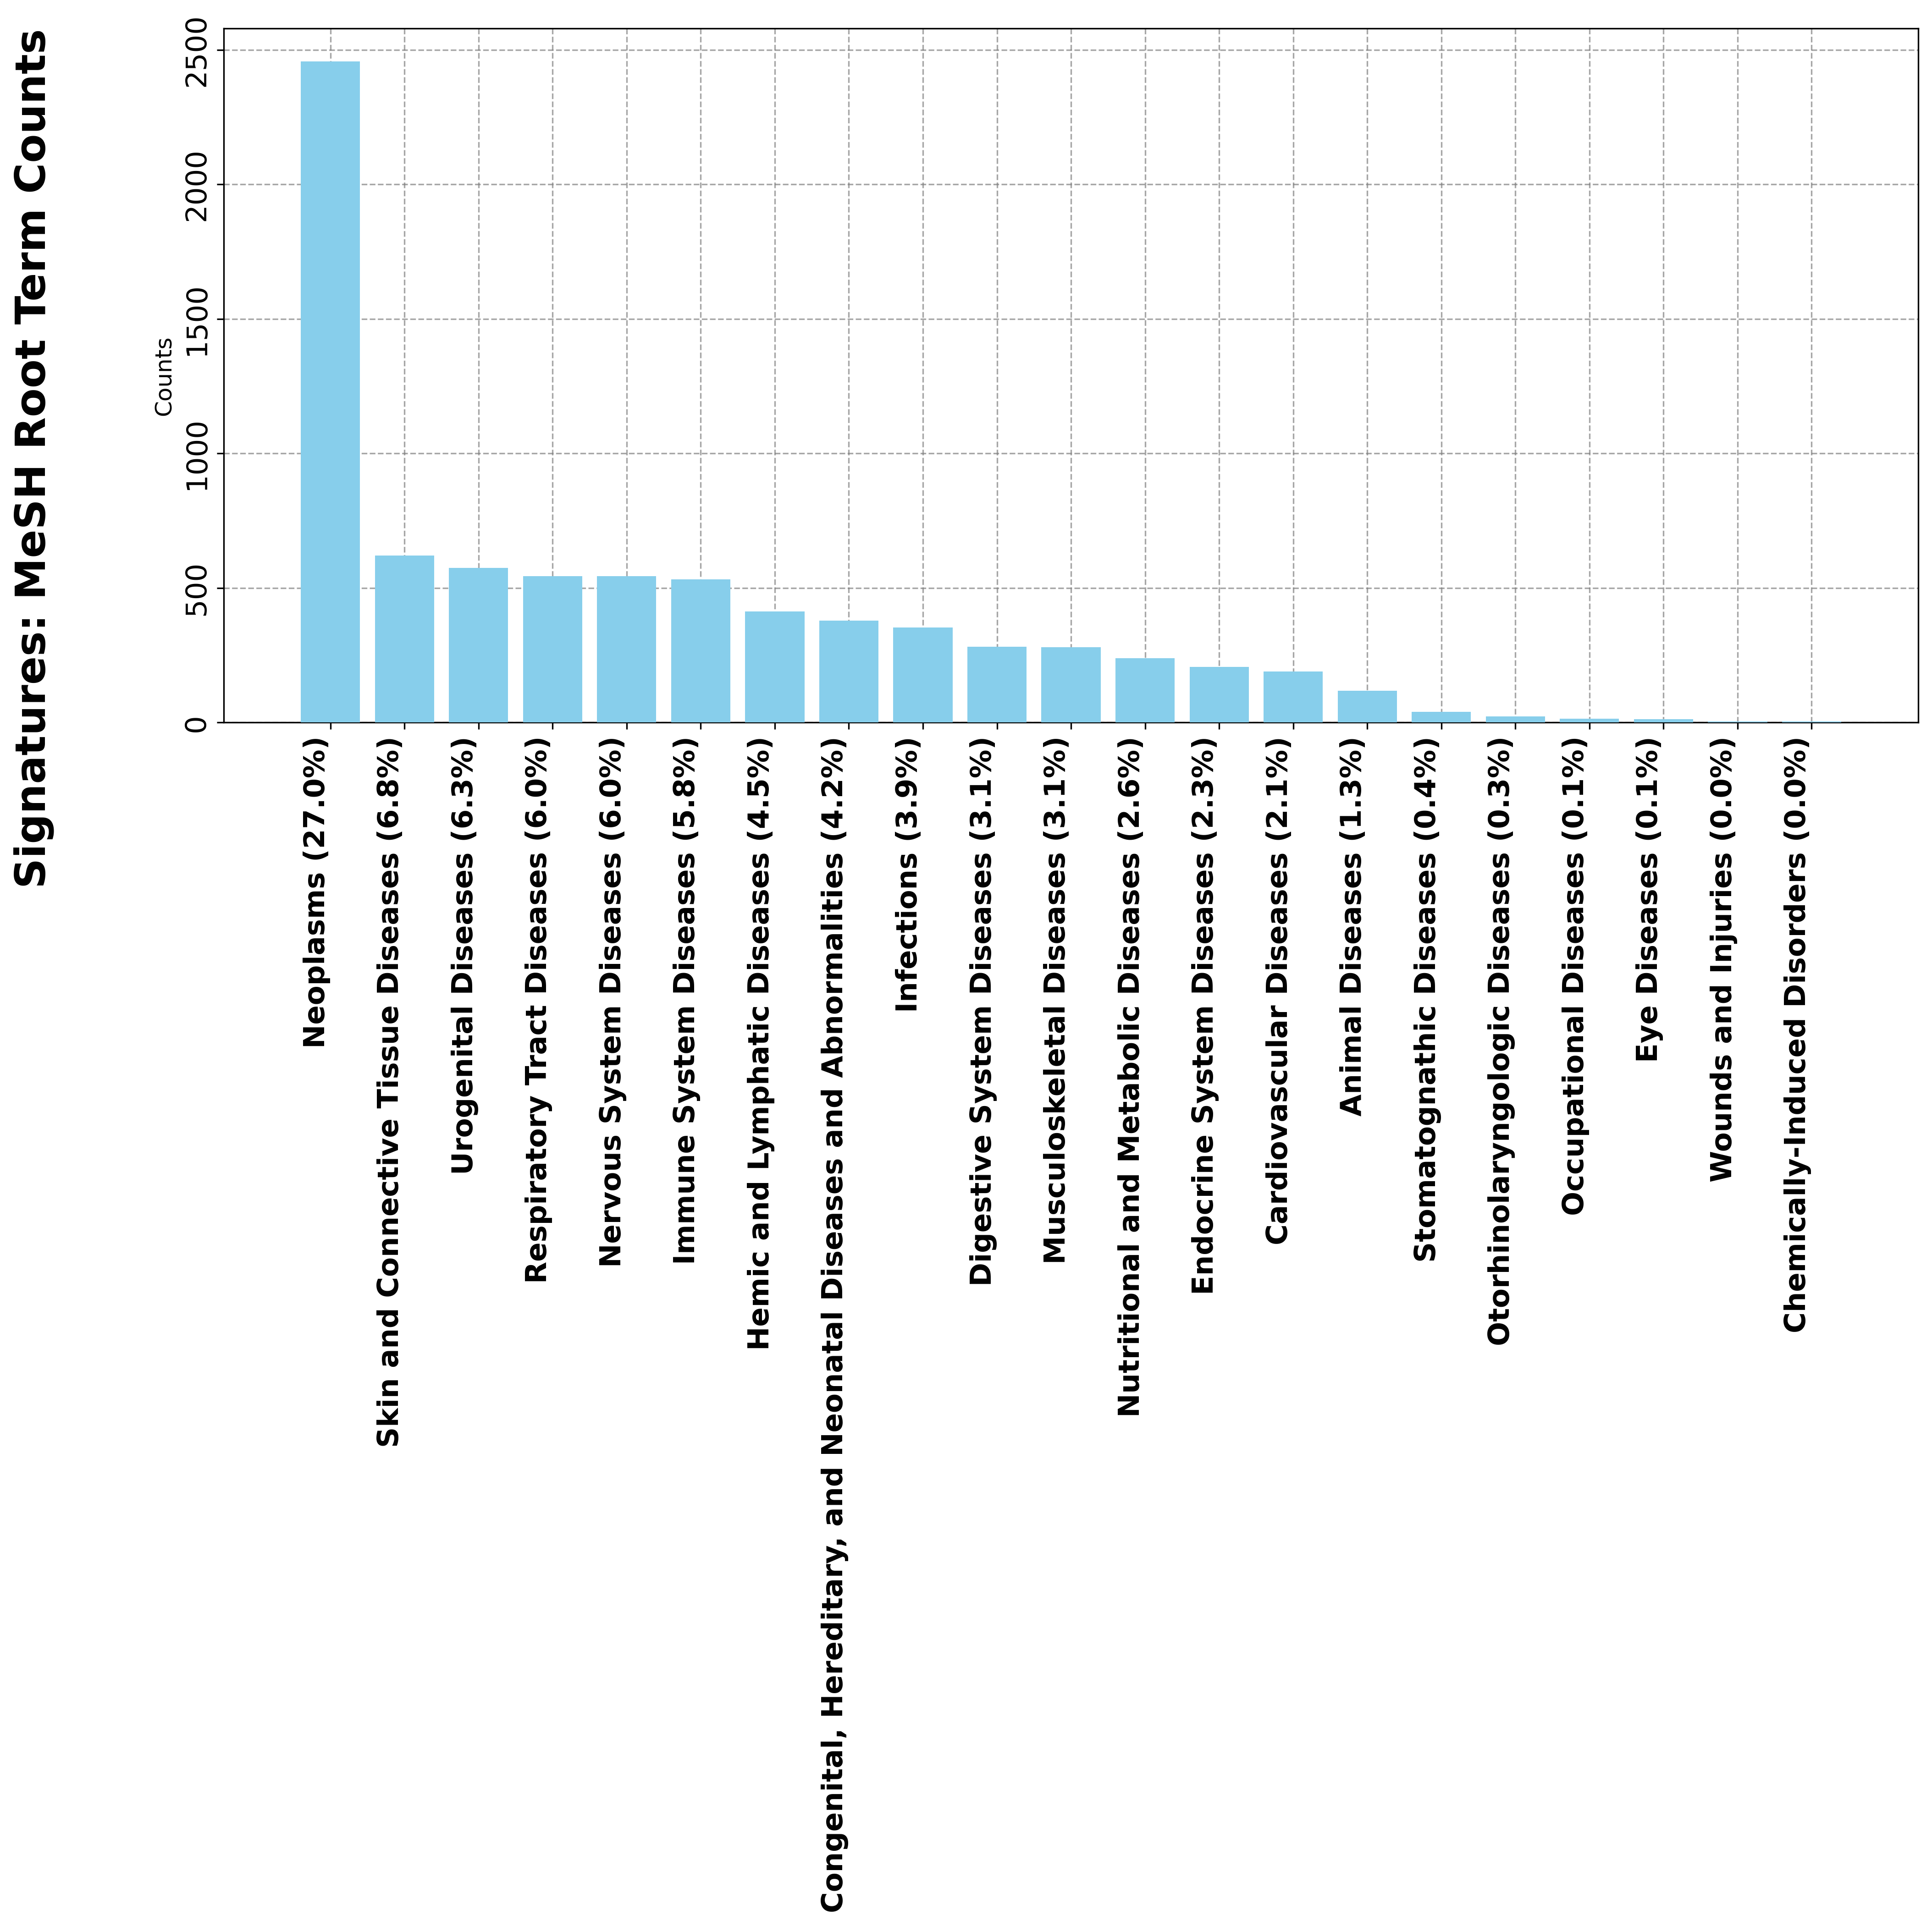

In [53]:
import matplotlib.pyplot as plt
from collections import Counter


# Count the occurrences of each category
category_counts = Counter(all_terms)


# Sort the categories by count in descending order
sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
labels, values = zip(*sorted_categories)
labels_perc = [f"{l} ({v/9097*100:.1f}%)" for l, v in zip(labels, values)]

# Create the bar plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 14), dpi=300)
plt.bar(labels_perc, values, color="skyblue", zorder=3)

# Add title and labels to the plot
# plt.title('MeSH Term Counts Hierarchy Level %d' %level,fontsize=22)

# Manually add a title-like text above the y-axis label
ax.text(
    -0.1,
    1,
    "Signatures: MeSH Root Term Counts",
    fontsize=22,
    transform=ax.transAxes,
    fontweight="bold",
    va="top",
    ha="right",
    rotation=90,
)

plt.ylabel("Counts", fontsize=12)

# Add grid lines with a white background
ax.set_facecolor("white")  # Set the background color to white

# plt.grid(axis='y', color='r', linestyle='--', alpha=0.7)
plt.grid(color="grey", linestyle="--", alpha=0.7, zorder=1)

# Add edges
ax.spines["bottom"].set_color("0")
ax.spines["top"].set_color("0")
ax.spines["right"].set_color("0")
ax.spines["left"].set_color("0")

# Rotate the category labels for better readability (if needed)
plt.yticks(rotation=90, va="center", fontsize=15)


# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, ha="right", fontsize=15, fontweight="bold")

# Show the plot
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.savefig(
    "../results/figures/iLINCS/numbers/n_mesh.signatures.root.png",
    dpi=300,
    bbox_inches="tight",
)

In [54]:
df = pd.DataFrame({"Specific MeSH Terms": labels, "Nº Signatures": values})
df.to_csv("../results/tmp/root_mesh_terms.csv", index=False)

#### f.2.2) MeSH terms for each signature - specific terms

In [175]:
# Get SPECIFIC terms ! ! !
# exclude terms that are not diseases
# exclude C23: Pathological Conditions, Signs and Symptoms

level = 0
level_split = level * 4 + 3
all_symbols = list()
filter_criteria = lambda t: t.startswith("C") and not t.startswith("C23")


def find_longest_string(lst):
    """Find Longets String in a list
    Parameters:
        lst: list()
    Return:
        longest: str()
    """
    longest = ""
    for item in lst:
        if len(item) > len(longest):
            longest = item
    # alternative
    # longest = max(lst, key=len)
    return longest


# root terms
root_terms = set([s[:3] for s in mesh_symbol_2_term.keys() if filter_criteria(s)])
all_symbols = list()

for k in datasets:
    symbols_dataset = list()
    if k in d_dataset_2_mesh.keys() and d_dataset_2_mesh[k]["symbol"] is not None:
        terms = d_dataset_2_mesh[k]["symbol"]
        # iterate through different root terms
        for root_term in root_terms:
            terms_for_root = [t for t in terms if t.startswith(root_term)]
            if len(terms_for_root) > 0:
                longest_length_term = find_longest_string(terms_for_root)

                symbols_dataset.extend(
                    [t for t in terms_for_root if len(t) == len(longest_length_term)]
                )
    if len(symbols_dataset) > 0:
        all_symbols.append(symbols_dataset)
    else:
        print(k)
        break


# translate terms
all_terms = list()

for sublist in all_symbols:
    for s in sublist:
        unique_terms = list(set(mesh_symbol_2_term[s]))
        all_terms.extend(unique_terms)

GDS690


In [168]:
len([k for k in d_dataset_2_mesh.keys() if d_dataset_2_mesh[k]["symbol"] is not None])

1036

In [178]:
success = list()
for k in d_dataset_2_mesh.keys():
    if d_dataset_2_mesh[k]["symbol"] is not None:
        if any([t.startswith("C") for t in d_dataset_2_mesh[k]["symbol"]]):
            success.append(k)

print(len(success))

748


In [170]:
d_dataset_2_mesh["gdsGDS4296"]

{'symbol': ['D27.505.954.248',
  'E05.196.401.143',
  'E05.301.300.096',
  'E05.478.566.320.200',
  'E05.601.262',
  'E05.601.470.320.200',
  'A11.251.210.190',
  'A11.251.860.180',
  'G04.161.750',
  'G07.345.249.410.750',
  'D08.811.399.403.483',
  'D12.776.157.687.375',
  'D12.776.660.720.375',
  'E05.478.566.350.170',
  'E05.478.566.380.360',
  'E05.478.583.400.170',
  'E05.601.470.350.170',
  'E05.601.470.380.360',
  'B01.050.150.900.649.313.988.400.112.400.400',
  'D02.455.426.559.847.486',
  'D04.615.486',
  'D03.633.100.531',
  'E05.196.712.516',
  'E05.588.570',
  'I01.409.418.750.600.650.496.150',
  'N03.540.052.750.150',
  'N03.540.348.500.500.600.650.496.150',
  'D13.444.735.544',
  'E05.393.620.500.725',
  'Z01.107.567.875'],
 'terms': ['Antineoplastic Agents',
  'Blotting, Western',
  'Cell Line, Tumor',
  'Cell Proliferation',
  'DNA Topoisomerases, Type I',
  'Enzyme-Linked Immunosorbent Assay',
  'Humans',
  'Indenes',
  'Isoquinolines',
  'Luminescent Measurements',
 

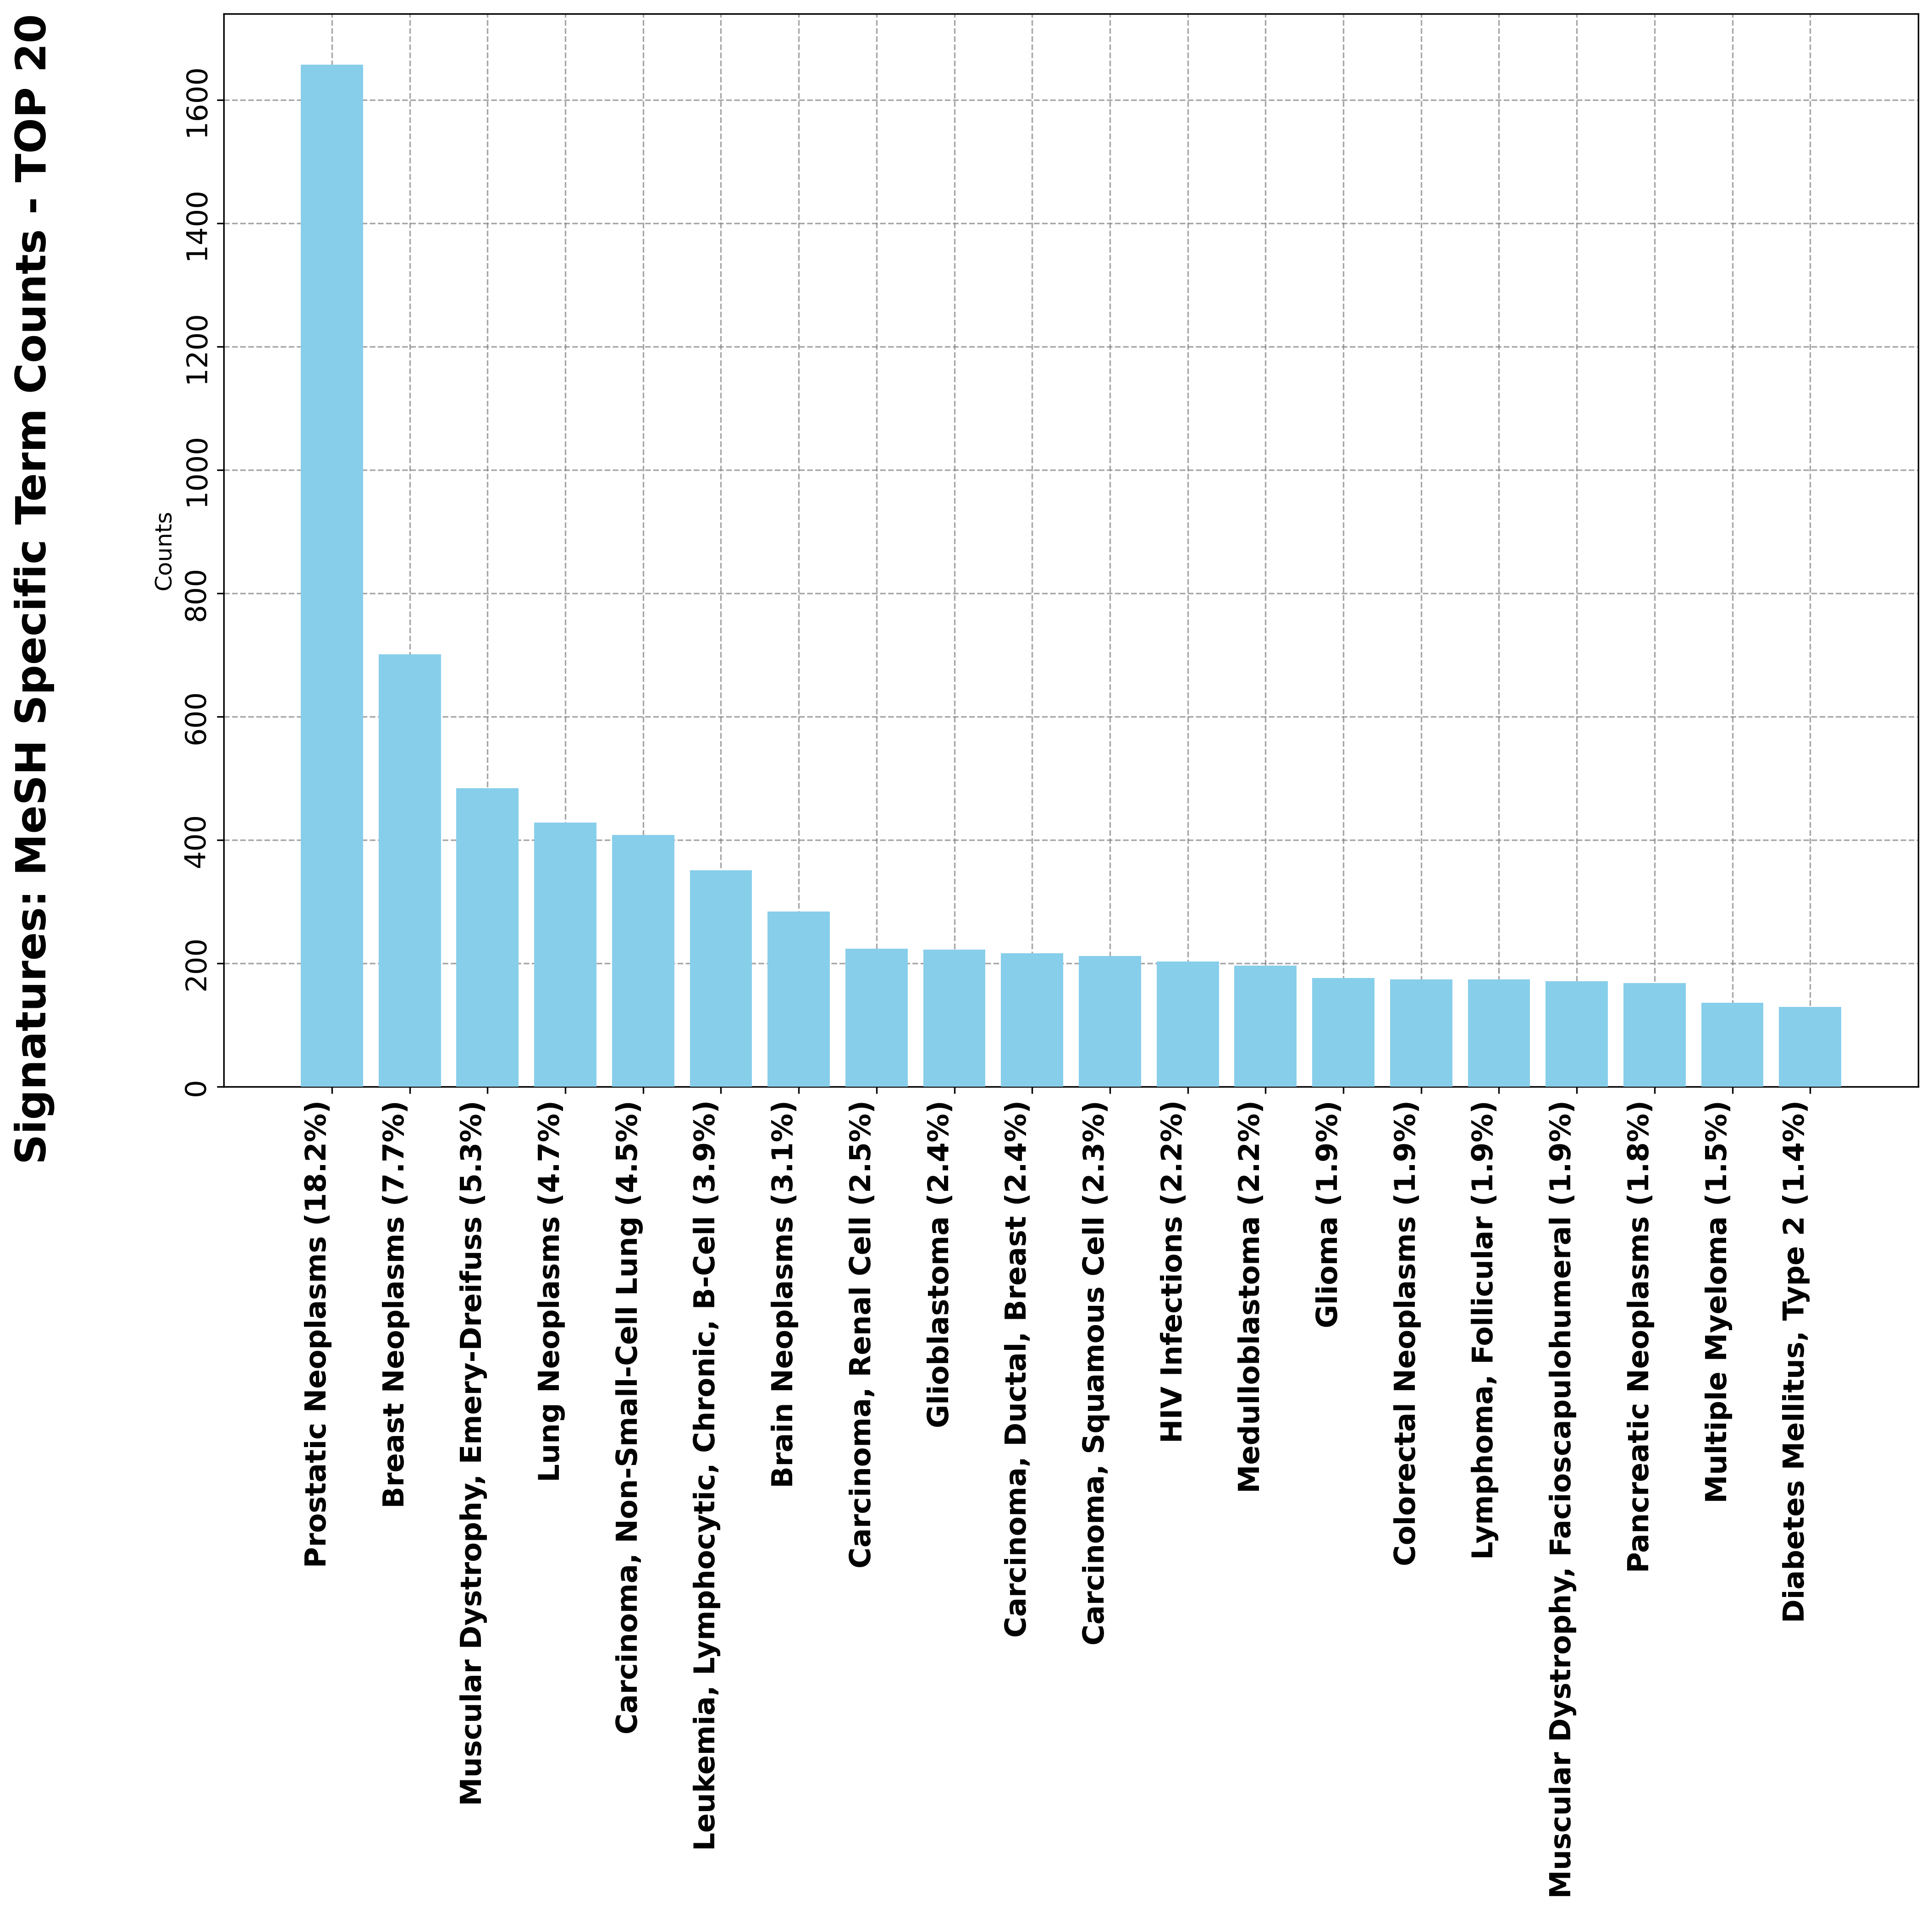

In [43]:
import matplotlib.pyplot as plt
from collections import Counter

# TOP N
top_n = 20

# Count the occurrences of each category
category_counts = Counter(all_terms)

# Sort the categories by count in descending order
sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
labels, values = zip(*sorted_categories)
labels_perc = [f"{l} ({v/9097*100:.1f}%)" for l, v in zip(labels, values)]

# Create the bar plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 14), dpi=300)
plt.bar(labels_perc[:top_n], values[:top_n], color="skyblue", zorder=3)

# Add title and labels to the plot
# plt.title('MeSH Term Counts Hierarchy Level %d' %level,fontsize=22)

# Manually add a title-like text above the y-axis label
ax.text(
    -0.1,
    1,
    f"Signatures: MeSH Specific Term Counts - TOP {top_n}",
    fontsize=22,
    transform=ax.transAxes,
    fontweight="bold",
    va="top",
    ha="right",
    rotation=90,
)

plt.ylabel("Counts", fontsize=12)

# Add grid lines with a white background
ax.set_facecolor("white")  # Set the background color to white

# plt.grid(axis='y', color='r', linestyle='--', alpha=0.7)
plt.grid(color="grey", linestyle="--", alpha=0.7, zorder=1)

# Add edges
ax.spines["bottom"].set_color("0")
ax.spines["top"].set_color("0")
ax.spines["right"].set_color("0")
ax.spines["left"].set_color("0")

# Rotate the category labels for better readability (if needed)
plt.yticks(rotation=90, va="center", fontsize=15)


# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, ha="right", fontsize=15, fontweight="bold")

# Show the plot
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.savefig(
    "../results/figures/iLINCS/numbers/n_mesh.sigantures.specific.png",
    dpi=300,
    bbox_inches="tight",
)

In [51]:
df = pd.DataFrame({"Specific MeSH Terms": labels, "Nº Signatures": values})
df.to_csv("../results/tmp/specific_mesh_terms.csv", index=False)

## DataFrame with MeSH terms

In [64]:
""" DataFrame with MeSH terms

Here we will generate a DataFrame which will have as rows MeSH terms and as columns
Nº of signatures, Nº of datasets, Nº of which have baseline normal/healthy/control condition,
Nº of which Factor is: cell line, disease state, time, agent, age, genotype/variation, specimen, 
protocol

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Create DataFrame
    4. Save DataFrame

"""

# 1. Imports, Variables, FunctionsROOT
import matplotlib.cm as cm
import logging
from Bio import Entrez
import requests
import xml.etree.ElementTree as ET
import time

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)


# variables
Entrez.email = "dylandaltonsub@gmail.com"
base_url = "http://www.ilincs.org/api"
doi_data_path = "../data/DiseaseOntology/doid.obo"
mesh_file_path = "../data/MeSH/desc2023.xml"
d_dataset_2_mesh = dict()
d_signature_2_mesh = dict()
d_mesh_symbol_2_term = dict()
filter_criteria = lambda s: (s["factor"] == "disease.state") and (
    "normal" in s["level2"] or "control" in s["level2"] or "healthy" in s["level2"]
)


# functions
def fetch_disease_signatures():
    """Fetch Disease Signatures"""
    endpoint = f"{base_url}/SignatureMeta"
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return []


def get_disease_datasets():
    """
    Get Disease Datasets
    Function to retrieve from those filtered signatures the datasetid

    Arguments:

    Return:
    datasetid: list()
        List of unique dataset id's
    """
    path_data = "../../data/iLINCS/signatures.csv"
    filter_df = lambda df: df["libraryid"] == "LIB_1"

    # Load Data
    try:
        df_data = pd.read_csv(path_data)
        logging.info("Data loaded successfully.")
    except FileNotFoundError:
        logging.error("Data file not found. Please check the file path.")
        exit()

    # filter disease signatures
    df_data = df_data[filter_df]

    return list(df_data["datasetid"].unique())


def build_mesh_term_tree_number_mapping(mesh_xml_file_path: str) -> dict:
    """
    Build a mapping of MeSH terms to their tree numbers from the MeSH XML file.

    Parameters:
    - mesh_xml_file_path (str): The file path to the MeSH XML file.

    Returns:
    - dict: A dictionary where keys are MeSH terms and values are lists of associated tree numbers.
    """
    tree = ET.parse(mesh_xml_file_path)
    root = tree.getroot()

    mesh_term_2_symbol = dict()
    mesh_symbol_2_term = dict()
    for descriptor in root.findall("DescriptorRecord"):
        term = descriptor.find("DescriptorName/String").text
        tree_numbers = [
            tree_number.text
            for tree_number in descriptor.findall("TreeNumberList/TreeNumber")
        ]
        for tree_number in tree_numbers:
            mesh_symbol_2_term[tree_number] = term
        mesh_term_2_symbol[term] = tree_numbers

    return mesh_term_2_symbol, mesh_symbol_2_term


# 2. Load Data
# load signatures
signatures = fetch_disease_signatures()


# load MeSH terms from datasets
# generated in SQL notebook
with open("../data/iLINCS/dataset_2_mesh.json", "r") as f:
    d_dataset_2_mesh_original = json.load(f)

# load mesh terms
mesh_term_2_symbol, mesh_symbol_2_term = build_mesh_term_tree_number_mapping(
    mesh_file_path
)

In [65]:
# Retrieve MeSH symbols
# we can retrieve from pmid the mesh terms but we need to map these to symbols
failed_translation_all = list()
d_dataset_2_mesh = dict()

for k, MeSH_terms in d_dataset_2_mesh_original.items():
    tree_symbols = list()
    terms = list()
    failed_translation = list()
    d_dataset_2_mesh[k] = dict()

    for MeSH_term in MeSH_terms[0]:
        try:
            tree_symbols.extend(mesh_term_2_symbol[MeSH_term])
            terms.append(MeSH_term)
            # print(mesh_term_2_symbol[MeSH_term])
        except:
            failed_translation.append(MeSH_term)
            failed_translation_all.append(MeSH_term)
    d_dataset_2_mesh[k]["symbol"] = tree_symbols
    d_dataset_2_mesh[k]["terms"] = terms

In [104]:
# map datasets to signatures
d_dataset_2_signature = dict()
for signature in [s for s in signatures if s["libraryid"] == "LIB_1"]:
    # if key has not been defined
    if signature["datasetid"] not in d_dataset_2_signature.keys():
        d_dataset_2_signature[signature["datasetid"]] = list()
    # else
    d_dataset_2_signature[signature["datasetid"]].append(signature)


# create list of root mesh terms
level = 0
level_split = level * 4 + 3
root_symbols = list()
filter_criteria = lambda t: t.startswith("C") and not t.startswith("C23")


for k in d_dataset_2_mesh.keys():
    if d_dataset_2_mesh[k]["symbol"] is not None:
        terms = d_dataset_2_mesh[k]["symbol"]

        terms_specific_level = list(
            set([t[:level_split] for t in terms if filter_criteria(t)])
        )
        root_symbols.extend(terms_specific_level)


# translate terms
root_terms = [mesh_symbol_2_term[s] for s in root_symbols]

# create list of leaf mesh terms
root_symbols_for_leaf = set(
    [s[:3] for s in mesh_symbol_2_term.keys() if filter_criteria(s)]
)
leaf_symbols = list()

for k in d_dataset_2_mesh.keys():
    if d_dataset_2_mesh[k]["symbol"] is not None:
        terms = d_dataset_2_mesh[k]["symbol"]
        # iterate through different root terms
        for root_term_for_leaf in root_symbols_for_leaf:
            terms_for_root = [t for t in terms if t.startswith(root_term_for_leaf)]
            if len(terms) > 0:
                longest_length_term = find_longest_string(terms_for_root)
                leaf_symbols.extend(
                    [t for t in terms_for_root if len(t) == len(longest_length_term)]
                )


# translate terms
leaf_terms = [mesh_symbol_2_term[s] for s in leaf_symbols]

In [142]:
# 3. Create DataFrame
# 3.1. Create DataFrame with root terms
# traverse through all mesh terms


d_data = list()

for mesh_symbol in set(root_symbols):
    # initialize data
    n_signatures = 0
    n_datasets = 0
    n_baseline = 0
    n_factor_cell_line = 0
    n_factor_time = 0
    n_factor_disease_state = 0
    n_factor_agent = 0
    n_factor_tissue = 0
    n_factor_age = 0
    n_factor_genotype = 0
    n_factor_specimen = 0
    n_factor_protocol = 0
    n_factor_cell_type = 0
    n_factor_other = 0

    # nº signatures with mesh term
    # get datasets w/ mesh term
    datasets_w_mesh_symbol = list()
    for k in d_dataset_2_mesh.keys():
        if mesh_symbol in [symbol[:3] for symbol in d_dataset_2_mesh[k]["symbol"]]:
            datasets_w_mesh_symbol.append(k)

    # get n of datasets
    n_datasets = len(datasets_w_mesh_symbol)

    # tranverse datasets w/ mesh terms
    n_signatures = 0
    for dataset in datasets_w_mesh_symbol:
        # traverse signatures from datasets
        for signature in d_dataset_2_signature[dataset]:
            # get n of signatures
            n_signatures += 1

            # get n of baseline
            # Keywords to check
            keywords = ["normal", "control", "healthy"]

            # Check if 'level1' is not None and if 'level2' is not None and contains any keyword
            if signature.get("level1") is not None:
                if signature.get("level2") is not None and any(
                    keyword in signature["level2"] for keyword in keywords
                ):
                    n_baseline += 1

            # get n factor
            n_factor_cell_line += 1 if signature["factor"] == "cell.line" else 0
            n_factor_time += 1 if signature["factor"] == "time" else 0
            n_factor_disease_state += 1 if signature["factor"] == "disease.state" else 0
            n_factor_agent += 1 if signature["factor"] == "agent" else 0
            n_factor_tissue += 1 if signature["factor"] == "tissue" else 0
            n_factor_age += 1 if signature["factor"] == "age" else 0
            n_factor_genotype += 1 if signature["factor"] == "genotype/variation" else 0
            n_factor_specimen += 1 if signature["factor"] == "specimen" else 0
            n_factor_protocol += 1 if signature["factor"] == "protocol" else 0
            n_factor_cell_type += 1 if signature["factor"] == "cell.type" else 0
            n_factor_other += 1 if signature["factor"] == "other" else 0
    d_data.append(
        {
            "Root MeSH Term": mesh_symbol_2_term[mesh_symbol],
            "Root MeSH Symbol": mesh_symbol,
            "Nº of Signatures": n_signatures,
            "Nº of Datasets": n_datasets,
            "Nº of Baseline": n_baseline,
            "Nº of Factor Cell Line": n_factor_cell_line,
            "Nº of Factor Time": n_factor_time,
            "Nº of Factor Disease State": n_factor_disease_state,
            "Nº of Factor Agent": n_factor_agent,
            "Nº of Factor Tissue": n_factor_tissue,
            "Nº of Factor Age": n_factor_age,
            "Nº of Factor Genotype": n_factor_genotype,
            "Nº of Factor Specimen": n_factor_specimen,
            "Nº of Factor Protocol": n_factor_protocol,
            "Nº of Factor Cell Type": n_factor_cell_type,
            "Nº of Factor Other": n_factor_other,
        }
    )

df_root = pd.DataFrame(d_data)

# 3.2. Create DataFrame with leaf terms
d_data = list()

for mesh_symbol in set(leaf_symbols):
    # initialize data
    n_signatures = 0
    n_datasets = 0
    n_baseline = 0
    n_factor_cell_line = 0
    n_factor_time = 0
    n_factor_disease_state = 0
    n_factor_agent = 0
    n_factor_tissue = 0
    n_factor_age = 0
    n_factor_genotype = 0
    n_factor_specimen = 0
    n_factor_protocol = 0
    n_factor_cell_type = 0
    n_factor_other = 0

    # nº signatures with mesh term
    # get datasets w/ mesh term
    datasets_w_mesh_symbol = list()
    for k in d_dataset_2_mesh.keys():
        if mesh_symbol in d_dataset_2_mesh[k]["symbol"]:
            datasets_w_mesh_symbol.append(k)

    # get nº of datasets
    n_datasets = len(datasets_w_mesh_symbol)

    # tranverse datasets w/ mesh terms
    n_signatures = 0
    for dataset in datasets_w_mesh_symbol:
        # traverse signatures from datasets
        for signature in d_dataset_2_signature[dataset]:
            # get n of signatures
            n_signatures += 1

            # get n of baseline
            # Keywords to check
            keywords = ["normal", "control", "healthy"]

            # Check if 'level1' is not None and if 'level2' is not None and contains any keyword
            if signature.get("level1") is not None:
                if signature.get("level2") is not None and any(
                    keyword in signature["level2"] for keyword in keywords
                ):
                    n_baseline += 1

            # get n factor
            n_factor_cell_line += 1 if signature["factor"] == "cell.line" else 0
            n_factor_time += 1 if signature["factor"] == "time" else 0
            n_factor_disease_state += 1 if signature["factor"] == "disease.state" else 0
            n_factor_agent += 1 if signature["factor"] == "agent" else 0
            n_factor_tissue += 1 if signature["factor"] == "tissue" else 0
            n_factor_age += 1 if signature["factor"] == "age" else 0
            n_factor_genotype += 1 if signature["factor"] == "genotype/variation" else 0
            n_factor_specimen += 1 if signature["factor"] == "specimen" else 0
            n_factor_protocol += 1 if signature["factor"] == "protocol" else 0
            n_factor_cell_type += 1 if signature["factor"] == "cell.type" else 0
            n_factor_other += 1 if signature["factor"] == "other" else 0

    d_data.append(
        {
            "Leaf MeSH Term": mesh_symbol_2_term[mesh_symbol],
            "Leaf MeSH Symbol": mesh_symbol,
            "Nº of Signatures": n_signatures,
            "Nº of Datasets": n_datasets,
            "Nº of Baseline": n_baseline,
            "Nº of Factor Cell Line": n_factor_cell_line,
            "Nº of Factor Time": n_factor_time,
            "Nº of Factor Disease State": n_factor_disease_state,
            "Nº of Factor Agent": n_factor_agent,
            "Nº of Factor Tissue": n_factor_tissue,
            "Nº of Factor Age": n_factor_age,
            "Nº of Factor Genotype": n_factor_genotype,
            "Nº of Factor Specimen": n_factor_specimen,
            "Nº of Factor Protocol": n_factor_protocol,
            "Nº of Factor Cell Type": n_factor_cell_type,
            "Nº of Factor Other": n_factor_other,
        }
    )

df_leaf = pd.DataFrame(d_data)


# 4. Save DataFrame
# save root csv
df_root_2 = df_root.drop("Root MeSH Symbol", axis=1).drop_duplicates()
print(f"df_root shape {df_root_2.shape}")
df_root_2.sort_values(by="Nº of Signatures", ascending=False, inplace=True)
df_root_2.to_csv("../results/tmp/root_mesh_terms.csv", index=False)


# save leaf csv
df_leaf_2 = df_leaf.drop("Leaf MeSH Symbol", axis=1).drop_duplicates()
print(f"df_leaf shape {df_leaf_2.shape}")
df_leaf_2.sort_values(by="Nº of Signatures", ascending=False, inplace=True)
df_leaf_2.to_csv("../results/tmp/leaf_mesh_terms.csv", index=False)

df_root shape (21, 15)
df_leaf shape (307, 15)


In [144]:
    for k in d_dataset_2_mesh.keys():
        if mesh_symbol in d_dataset_2_mesh[k]["symbol"]:
            datasets_w_mesh_symbol.append(k)

In [147]:
if mesh_symbol in d_dataset_2_mesh[k]["symbol"]:
    print("yes")

In [ ]:
if "a" 

In [143]:
df_leaf_2

,Leaf MeSH Term,Nº of Signatures,Nº of Datasets,Nº of Baseline,Nº of Factor Cell Line,Nº of Factor Time,Nº of Factor Disease State,Nº of Factor Agent,Nº of Factor Tissue,Nº of Factor Age,Nº of Factor Genotype,Nº of Factor Specimen,Nº of Factor Protocol,Nº of Factor Cell Type,Nº of Factor Other
21,Breast Neoplasms,491,87,34,58,59,64,95,3,0,34,32,29,2,89
170,Lung Neoplasms,352,23,19,4,20,37,23,5,153,6,0,2,2,95
41,Prostatic Neoplasms,285,36,32,6,58,32,16,19,0,12,66,20,10,38
228,Neoplasm Metastasis,258,24,35,34,28,41,1,25,0,5,66,18,1,37
88,"Carcinoma, Squamous Cell",216,16,12,1,18,36,4,3,0,0,0,3,0,147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,"Osteoarthritis, Knee",1,1,0,0,0,0,0,0,0,0,0,0,1,0
115,"Dysentery, Amebic",1,1,0,0,1,0,0,0,0,0,0,0,0,0
127,Epidermolysis Bullosa Simplex,1,1,0,0,0,1,0,0,0,0,0,0,0,0
12,"Dermatitis, Contact",1,1,0,0,0,0,1,0,0,0,0,0,0,0


In [122]:
i = 0
for mesh_symbol in set(leaf_symbols):
    i += 1
print(i)

655


In [128]:
len(set(root_terms))

22

In [130]:
len(set(leaf_terms))

307

In [131]:
len(set([mesh_symbol_2_term[s] for s in leaf_symbols]))

307

In [123]:
len(set(leaf_symbols))

655

In [137]:
df_leaf_2 = df_leaf.drop("Leaf MeSH Symbol", axis=1).drop_duplicates()
df_leaf_2.shape

(307, 15)

In [92]:
keywords = ["normal", "control", "healthy"]

# Check if 'level1' is not None and if 'level2' is not None and contains any keyword
if signature.get("level1") is not None:
    if signature.get("level2") is not None and any(
        keyword in signature["level2"] for keyword in keywords
    ):
        n_baseline += 1